#OA3802 Lab 2: Movie Ratings (SQL)
###Travis Farwell
This lab shows examples of how to connect and query an SQL database with python and the pymysql module. The code below imports the module and assigns values to authentication variables needed to connect to the database.  

In [41]:
import pymysql
host="farwell-lab2db.cuocw7whxkhb.us-east-2.rds.amazonaws.com"
port=3306
dbname="Lab2Database"
user="farwell_lab2db"
password="6yhnMJU&8ik,>LO("
mydb = pymysql.connect(host=host,port=port,user=user,passwd=password,db = dbname)
sql = mydb.cursor()

##What are the Top 10 (highest rated) movies based on average user rating?

The code below executes an sql query with the execute function by sending a string as a query. The query first joins the movies and ratings tables by the movieId. We can think of this intermediary table as having at least one row for each entry in the movies and ratings table. There will only be one row for each rating. Each rating will be matched to a movie. This is known as a one-to-many relationship. Since we want average rating for each movie we must some how group the ratings by movie. The GROUP BY clause does this. We group by movies so that each rating corresponds to the correct movie. Now to use aggregate functions. Since we want average rating we use the function AVG() to get the average rating of each movie. This is both used in the SELECT statement and ORDER BY. SELECT specifies what columns or values we want returned. The average ratings are sorted using ORDER BY in descending order. Since the top 10 ratings are desired LIMIT is used to only return the first 10 results of the query. 

What is the HAVING clause there for? If the query is fetched without it, many movies will return with a rating of 5 but from a sample of only 1 which isn't enough for the central limit theorem to be present. A sample of 20 should suffice to include only movies with a large enough sample. The HAVING clause only returns movies with more than 20 ratings.

In [42]:
sql.execute("SELECT movies.title, AVG(ratings.rating)\
    FROM movies, ratings \
    WHERE movies.movieId = ratings.movieId \
    GROUP BY movies.movieId \
    HAVING COUNT(ratings.rating) > 20 \
    ORDER BY AVG(ratings.rating) DESC \
    LIMIT 10")
results = sql.fetchall()

Now some editing is done so the query can be displayed in a presentable format. The first line below creates a new list of lists using a list comprehension. The index number plus 1 is added to each list so we know what place the movie rates and the rating is rounded to two decimal places. Some regular expressions are used to do some formatting to the movies' titles. I remove everything between parenthesis such as the date and any aliases using the regex \(.*\). Then if the title contains ', The', this is stripped and 'The ' is added to the beggining of the title. Then using display, HTML, and tabulate modules, a table of the top 10 average ratings is easily displayed. 

In [35]:
tab = [[i+1,results[i][0],str(round(results[i][1],2))] for i in range(len(results))]

def format_string(tab):
    import re
    tab = re.sub(r'\(.*\)','',tab)
    if re.search(r', The',tab):
        tab = "The " + re.sub(r', The', '', tab)
    return tab
    
for i in range(len(tab)):
    tab[i][1] = format_title(tab[i][1])
    
from IPython.core.display import display, HTML 
import tabulate
tab.reverse()
display(HTML(tabulate.tabulate(tab, tablefmt='html',headers=['Number','Title','Rating(avg)'])))

Number,Title,Rating(avg)
10,The Godfather: Part II,4.39
9,Band of Brothers,4.39
8,The Maltese Falcon,4.39
7,Roger & Me,4.39
6,The African Queen,4.42
5,Ran,4.42
4,All About Eve,4.43
3,On the Waterfront,4.45
2,The Shawshank Redemption,4.49
1,The Godfather,4.49


##What is the most-tagged movie and what tags are associated with it?

For this task a similar query is first fetched. The query matches each movieId in the movies and tags tables so that the amount of tags for each movie can be counted. In the GROUP BY statement, each movie is grouped together by movieId that way each tag is matched to only one movie. The aggregate function COUNT is used to count how many tags each movie is matched to in the ORDER BY statement. The counts are ordered in descending fashion using DESC. The last statement limits the amount of records recieved to 1 since the task is to find the one movie with the most tags. Now that the top movie is found, the value of the movie's id and title are stored in variables for future use. Another query is sent using the movieId of the top movie. This returns all of the tags that correspond to the movie identified in the first query.

In [43]:
sql.execute("\
    SELECT movies.movieId, tags.tag, movies.title\
    FROM movies, tags \
    WHERE movies.movieId = tags.movieId \
    GROUP BY movies.movieId \
    ORDER BY COUNT(tags.tag) DESC \
    LIMIT 1")
results = sql.fetchall()
movieId = results[0][0]
title = results[0][2]
sql.execute("\
    SELECT tags.tag\
    FROM movies, tags \
    WHERE movies.movieId = " + str(movieId) + " AND movies.movieId = tags.movieId")
results = sql.fetchall()

What are the tags associated with the movie with the top tags? A module called wordcloud will be used to help visualize the words used to tag the movie. First the module is loaded along with some additional ones. Three list comprehensions are used to parse the tags. Since the results from the query are fetched and stored in a tuple of tuples, we iterate through each tuple and use the split() method to strip the spaces and store the words in a list of lists. Then each word in each list is converted to lower case and stored in a list individually. The final comprehension uses the sub() method from the re module (regular expression) to remove any non-letter characters and substitute these characters with an empty string. The movie title is formatted using the format_string helper function from above. Now the words are fed to the WordCloud function to create the visulization. WordCloud() calls a method generate() which takes in a string as input. For this, a string is created from the list of words and fed to the method. The title of the movie is added as the title of the wordcloud.

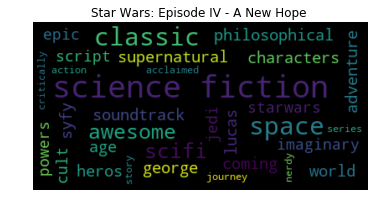

In [44]:
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import wordcloud

words = [str.split(w) for tup in results for w in tup]
words = [j.lower() for i in words for j in i]
words = [re.sub("[!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]", '', text) for text in words]

title = format_string(title)
word = ""
for w in words:
    word = word + " " + w
wc = WordCloud(max_words=1000,  margin=10, random_state=1).generate(word)
default_colors = wc.to_array()
plt.title(title)
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()

##What are the top three action movies 

Now to find the top three movies of a certain genre. The movies, tags, and ratings tables are all needed for this query. This is specified in the FROM clause. Since a certain genre is wanted we need to somehow find tags that represent the genre. By using LIKE and SQL's own regex-like expressions we find these by finding tags LIKE '%action%'. The % symbols before and after the word mean to find 'action' anywhere in the string. Also in the WHERE clause each movie is matched to the tag by movieId and each movie is matched to it's corresponding ratings the same way. AND is used between each statement so only events that satisfy all requirements are found. The movies are then grouped by movieId and ordered by average ratings in by highest average rating to lowest. The top three movies are displayed exactly as in the first task. The code is wrapped in a function so the user can easily specify the genre and number of movies wanted to be returned.


In [53]:
def top_movies_by_genre(genre = 'drama', top = 10):
    sql.execute("SELECT movies.title, AVG(ratings.rating) \
        FROM movies, tags, ratings \
        WHERE tags.tag LIKE '%" + genre + "%' AND movies.movieId = tags.movieId  AND movies.movieId = ratings.movieId   \
        GROUP BY movies.movieId \
        ORDER BY AVG(ratings.rating) DESC \
        LIMIT "+ str(top) + "")
    results = sql.fetchall()

    tab = [[i+1,results[i][0],str(round(results[i][1],2))] for i in range(len(results))]
    for i in range(len(tab)):
        tab[i][1] = format_title(tab[i][1])

    tab.reverse()
    display(HTML(tabulate.tabulate(tab, tablefmt='html',headers=['Number','Title','Rating(avg)'])))
    
top_movies_by_genre('action',top = 3)

Number,Title,Rating(avg)
3,The Road Warrior,3.79
2,Star Wars: Episode VI - Return of the Jedi,4.06
1,Star Wars: Episode IV - A New Hope,4.22
